# **Import libraries and read dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing essential libraries and functions
import pandas as pd
import numpy as np
import re
import nltk
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dense
from keras.layers import  Embedding, LSTM
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#read dataset from google drive and skip on the bad lines
data = pd.read_csv('/content/drive/MyDrive/dataset.txt', sep='\t', on_bad_lines='skip' )

#select a subset of dataset contain mentioned columns below
data=data[['review_body','star_rating']]

In [ ]:
#determine the sentiment for each 'review_body' and add it to sentiment column
data['sentiment']=''
data['sentiment']=np.where((data['star_rating'] < 3), 'negetive', data['sentiment'])
data['sentiment']=np.where((data['star_rating'] > 3 ), 'positive', data['sentiment'])
data['sentiment']=np.where((data['star_rating'] == 3), 'neutral', data['sentiment'])

In [ ]:
data.head()

review_body  star_rating sentiment
0  Absolutely love this watch! Get compliments al...            5  positive
1       I love this watch it keeps time wonderfully.            5  positive
2                                          Scratches            2  negetive
3  It works well on me. However, I found cheaper ...            5  positive
4  Beautiful watch face.  The band looks nice all...            4  positive

# **Data Preprocessing**

In [ ]:
def text_Preprocessing(text):
  reviews=[text.lower() for text in text]                      #convert text to lower case
  reviews=[re.sub(r'\d+','',text) for text in reviews]         #remove digits
  reviews=[re.sub(r'\S+@\S+','',text) for text in reviews]     #remove email
  reviews=[re.sub(r'^\w\s','',text) for text in reviews]       #remove alphanumeric values
  reviews=[re.sub(r'[^A-Za-z]+',' ',text) for text in reviews] #remove non words characters
  reviews=[text.strip() for text in reviews]                   #remove extra spaces

  stop_words=set(stopwords.words('english'))
  cleaned_reviews=[]
  lem_reviews=[]

  for review in reviews:
    tokens=[word for word in word_tokenize(review) if not word in stop_words]
    cleaned_reviews.append(" ".join(tokens))
  lemmatizer=WordNetLemmatizer()
  for review in cleaned_reviews:
    lem_reviews.append(" ".join(list(map(lemmatizer.lemmatize, word_tokenize(review)))))
  return lem_reviews

In [ ]:
#execute text_Preprocessing method on 'review_body' column items
X = []
review_body = list(data['review_body'])
for item in review_body:
    X.append(text_Preprocessing(item))

#Y is like the sentiment column
#if item in sentiment column is positive we put one in Y otherwise we put zero in Y
Y = data['sentiment']
Y = np.array(list(map(lambda x: 1 if x=="positive" else 0, Y)))

In [ ]:
#split dataset to tarin and test ==> train=80%  test=20%
#random_state=42 means train_test_split output is same each time
#X_train and X_test contain 'review_body'
#Y_train and Y_test contain sentiments
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# **Preparing Embedding layer**

In [ ]:
word_tokenizer = Tokenizer() # initializes an instance of the Tokenizer class
word_tokenizer.fit_on_texts(X_train) # builds the vocabulary based on the text in X_train and assigns a unique integer index to each word in the vocab

X_train = word_tokenizer.texts_to_sequences(X_train) #ensures that the test data is represented in the same way as the training data
X_test = word_tokenizer.texts_to_sequences(X_test) #variables will contain sequences of integers representing the tokenized versions of the original texts.

In [ ]:
vocab_length = len(word_tokenizer.word_index) + 1 #calculates the vocab size

In [ ]:
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen) # adds padding to the train seq to make them same length
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen) # applies padding using the same parameters as training

In [ ]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict() # making a dict
glove_file = open('/content/drive/MyDrive/a2_glove.6B.100d.txt', encoding="utf8") #opens the file containing the pre-trained

for line in glove_file: # reads each line in the glove_file
    records = line.split() # splits the current line into a list of values based on whitespace
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')  # converts the remaining elements of the records list into a numerical NumPy array
    # float32 =  specify a 32-bit floating-point
    embeddings_dictionary [word] = vector_dimensions # assigns the word as the key and vector as the value
glove_file.close() # closing the file

In [ ]:
embedding_matrix = zeros((vocab_length, 100)) # creates an embedding matrix with size of vocab_length and 100 and all the cells fulled with 0
for word, index in word_tokenizer.word_index.items(): # iterates over each word and its corresponding(متناظر) index
    embedding_vector = embeddings_dictionary.get(word) # retrieves the pre-trained embedding vector for the current word
    # If the word is present in the embeddings_dictionary, its corresponding embedding vector is assigned to embedding_vector. Otherwise, embedding_vector will be None
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector # assigns the embedding vector to the corresponding row in the embedding matrix

# **LSTM**

In [ ]:
# Neural Network architecture

lstm_model = Sequential()# creates a Sequential model, which allows building stack layers sequentially
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False) #defines an Embedding layer
# 100: The dimensionality of the word embeddings.
# trainable=False: Freezes the embedding layer so that its weights are not updated during training
# weights=[embedding_matrix]: Specifies the pre-trained word embeddings to be used


lstm_model.add(embedding_layer) # adds the embedding layer to the model
lstm_model.add(LSTM(128)) # adds an LSTM layer with 128 units to the model
lstm_model.add(Dense(1, activation='sigmoid')) # adds Dense layer

In [ ]:
# Model compiling
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# loss='binary_crossentropy' --> commonly used for binary classification problems
# optimizer='adam': Specifies the Adam optimizer
# Defines the evaluation metric as accuracy

In [ ]:
# Model Training
lstm_model_history = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
2/2 [==============================] - 4s 746ms/step - loss: 0.6890 - acc: 0.5606 - val_loss: 0.6596 - val_acc: 0.7647
Epoch 2/6
2/2 [==============================] - 0s 152ms/step - loss: 0.6390 - acc: 0.7348 - val_loss: 0.6797 - val_acc: 0.7647
Epoch 3/6
2/2 [==============================] - 0s 156ms/step - loss: 0.6402 - acc: 0.7348 - val_loss: 0.6989 - val_acc: 0.7647
Epoch 4/6
2/2 [==============================] - 0s 152ms/step - loss: 0.6495 - acc: 0.7348 - val_loss: 0.6823 - val_acc: 0.7647
Epoch 5/6
2/2 [==============================] - 0s 153ms/step - loss: 0.6392 - acc: 0.7348 - val_loss: 0.6662 - val_acc: 0.7647
Epoch 6/6
2/2 [==============================] - 0s 150ms/step - loss: 0.6303 - acc: 0.7348 - val_loss: 0.6565 - val_acc: 0.7647


# **Evaluate Model**

In [ ]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, Y_test, verbose=1)
print("Test Score:", score[0])
print("test accuracy: {:.2f}%".format(score[1]*100))
#X_train: input training data (padded sequences)
#Y_train: The target training labels
#batch_size=128: Specifies the number of samples to be used in each training batch This parameter controls how often the model's weights are updated.
#epochs=6: Sets the number of times the model will iterate over the entire training dataset
#verbose=1: Specifies the level of verbosity during training Setting to 1 --> displays progress bars and training information.
#validation_split=0.2: Splits a portion of the training data for validation. In this case, 20% of the training data is reserved for validation, while the remaining 80% is used for training

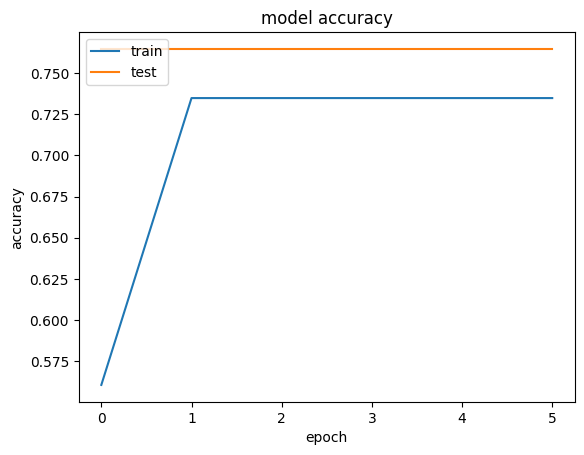

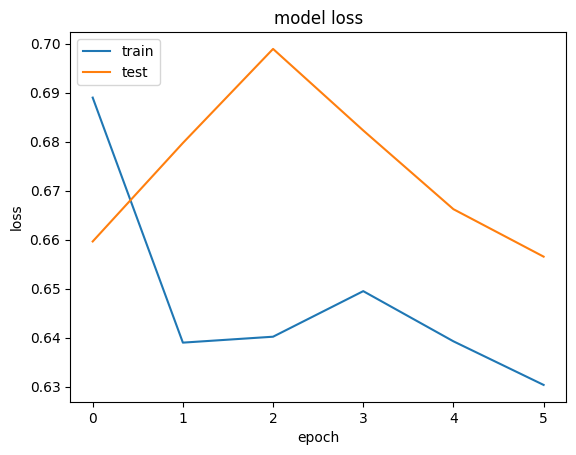

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt


plt.plot(lstm_model_history.history['acc']) # Plots the training accuracy and lstm_model_history.history['acc'] contains the accuracy values for each epoch on the training set.
plt.plot(lstm_model_history.history['val_acc']) #  Plots the validation accuracy

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left') # Adds 'train' corresponds to the training accuracy, and 'test' corresponds to the validation accuracy.
plt.show()

plt.plot(lstm_model_history.history['loss']) #  Plots the training loss
plt.plot(lstm_model_history.history['val_loss']) # Plots the validation loss

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

در این قسمت به مقایسه دو بخش الف و ب میپردازیم.  با توجه به دستیابی  به خروجی   شبکه عصبی برابر با 87.33 و رسیدن به خروجی 85.76 برای رگرشن منطقی میتوان نتجیه گرفت که شبکه عصبی عملکرد بهتری داشته است

